In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ExponentialLR
from torch import nn, vmap
from time import time
import os, sys, math
torch.manual_seed(0)

In [2]:

# dimension
D = 10

# domain width
L = 1.0

In [3]:
# path simulation time
T = .6

# Total umber of paths
M_tot = 100000

# Batch size of each epoch
M = 10000

# number of grid points
N = 60

# number of grid points at the boundaries
N_bdry = 5000

# number of collocation points for evaluating the integral
N_test = 1000

# number of training epochs
n_epoch = 30000

In [4]:
# rhs
def u_true(x):
    return (np.pi / 2 / L * x).cos().prod()

In [5]:
# time step size
dt = T / N
dBt = np.sqrt(dt)

def sample_NDstdBM_paths(M: int, D: int, T: float, N: int):
    return torch.cumsum(
        torch.concat([
            torch.zeros(M, 1, D),
            torch.randn(M, N, D) * np.sqrt(T / N)
        ], dim=1), dim=1
    )


W_tot = sample_NDstdBM_paths(M_tot, D, T, N)

In [6]:
def mask_NDstdBM_paths(paths, L: float):
    oob = paths.abs().max(dim=2)[0].le(L).double()
    return oob.cummin(dim=1).values, oob.argmin(dim=1)

mask, exit_idx = mask_NDstdBM_paths(W_tot, L)
print(f"Boundary unreached rate: {mask[:, -1].sum().item() / M_tot * 100}%")

Boundary unreached rate: 1.442%


In [7]:
def sample_boundary_points(N_bdry: int, D: int, L: float):
    rand_u = torch.rand(N_bdry, D) - 0.5
    return rand_u / rand_u.abs().max(dim=1)[0].unsqueeze(dim=1) * L


X_bdry = sample_boundary_points(N_bdry, D, L)

In [8]:
class Sin(nn.Module):
    def __init__(self):
        super(Sin, self).__init__()

    def forward(self, x):
        return torch.sin(x)

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.eigval = nn.Parameter(torch.tensor(0.))
        self.eigfun = nn.Sequential(
            nn.Linear(D, 20),
            nn.GELU(),
            nn.Linear(20, 10),
            nn.GELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.eigfun(x)

u = DNN()
# u.load_state_dict(torch.load("the_network.pt"))

In [9]:
X_test = torch.randn(N_test, D)
X_test = X_test / X_test.norm(dim=1).unsqueeze(dim=1) * torch.rand(N_test, 1) * L

optimizer = torch.optim.Adamax(u.parameters(), lr=.02, )
scheduler = ExponentialLR(optimizer, gamma=0.995)

loss_rec = np.zeros(n_epoch + 1)
l2_err_rec = np.zeros(n_epoch + 1)
l2_norm_rec = np.zeros(n_epoch + 1)
eig_rec = np.zeros(n_epoch + 1)

In [10]:
start_time = time()
u_saved = u
min_loss = 1e+50
for i in range(n_epoch):
    batch_idx = torch.randint(0, M_tot, (M,))
    W = W_tot[batch_idx]
    u_val = vmap(u)(W).squeeze()
    u_val_bdry = u(X_bdry).squeeze()
    loss_mart = ((u_val[:, 1:] - u_val[:, :-1] - (u.eigval * u_val[:, :-1]) / 2. * dt)
                 * mask[batch_idx, :-1]).mean(axis=0).pow(2).sum() / T

    # loss_mart = ((u_val[:, 3:] - u_val[:, :-3] - (u.eigval * (
    #     (u_val[:, 3:] + u_val[:, :-3]) / 2 + u_val[:, 2:-1] + u_val[:, 1:-2]
    # )) * dt)
    #              * mask[batch_idx, :-3]).mean(axis=0).pow(2).sum() / T
    
    # If one wants to change boundary point every epoch, uncomment the following:
    X_bdry = sample_boundary_points(N_bdry, D, L)
    
    loss_bdry = (u(X_bdry).squeeze()).pow(2).sum() / N_bdry
    loss_0 = (u(torch.zeros(D)) - 1.) ** 2
    loss = loss_mart + .5 * loss_bdry + 100. * loss_0
    if n_epoch > 101:
        loss += 0.25e-7 * (u.eigval - eig_rec[-100]) ** 2
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        scheduler.step()
    optimizer.zero_grad()

    if min_loss > loss.item():
        min_loss = loss.item()
        u_saved = u

    loss_rec[i] = loss.item()
    eig_rec[i] = u.eigval.item()

    u_test_val = u(X_test).squeeze()
    u_true_val = vmap(u_true)(X_test).squeeze()
    L2_loss = torch.sqrt((u_test_val - u_true_val).pow(2).sum() / N_test)
    L2_norm = torch.sqrt(u_test_val.pow(2).sum() / N_test) 
    l2_err_rec[i] = L2_loss.item()
    l2_norm_rec[i] = L2_norm.item()
    if i % 100 == 0 or i == n_epoch - 1:
        print(f"round {i}, loss={loss.item()}, L2 error={L2_loss.item()}, L2 norm={L2_norm.item()}, eig={u.eigval.item()}")

end_time = time()

print(f"Training finished in {end_time - start_time} seconds.")
print("Now saving the results ... ", end="")
torch.save(u_saved.state_dict(), os.path.join(".", "the_network.pt"))
np.savez("loss_and_err.npz", loss_rec=loss_rec, l2_err_rec=l2_err_rec, eig_rec=eig_rec)
print("done.")
print("Congratulations! Everything is done.")

round 0, loss=138.82901000976562, L2 error=0.8322926759719849, L2 norm=0.10490546375513077, eig=0.019978471100330353
round 100, loss=0.05359817296266556, L2 error=0.27791827917099, L2 norm=0.9097734093666077, eig=-1.4073143005371094
round 200, loss=0.032447151839733124, L2 error=0.2630637586116791, L2 norm=0.901393711566925, eig=-3.0959417819976807
round 300, loss=0.024814346805214882, L2 error=0.2539568841457367, L2 norm=0.8951480984687805, eig=-4.4764251708984375
round 400, loss=0.02028072439134121, L2 error=0.2458735704421997, L2 norm=0.8894833922386169, eig=-5.5717597007751465
round 500, loss=0.017545510083436966, L2 error=0.23696385324001312, L2 norm=0.8831661939620972, eig=-6.454152584075928
round 600, loss=0.014640389010310173, L2 error=0.22767938673496246, L2 norm=0.8765204548835754, eig=-7.196661949157715
round 700, loss=0.01326278317719698, L2 error=0.21712762117385864, L2 norm=0.8689865469932556, eig=-7.85759973526001
round 800, loss=0.011487331241369247, L2 error=0.20683945

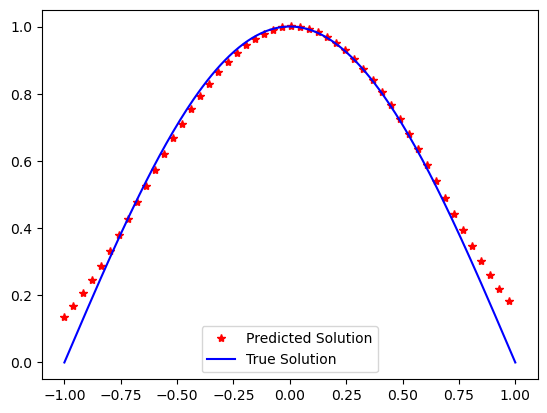

In [10]:
u.load_state_dict(torch.load("the_network.pt"))
x_test = torch.linspace(-1, 1, 200).unsqueeze(dim=1) * (torch.tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
# x_test = torch.linspace(-1, 1, 200).unsqueeze(dim=1) * (torch.tensor([1.]))


plt.plot(np.linspace(-L, L, 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "r*")
plt.plot(np.linspace(-L, L, 200), vmap(u_true)(x_test).detach().numpy(), "b")
plt.legend(["Predicted Solution", "True Solution"])
plt.savefig("200d_axis.png")
plt.show()

In [12]:
-u.eigval

tensor(24.7830, grad_fn=<NegBackward0>)

In [13]:
(np.pi / 2 / L) ** 2 * D

24.674011002723397

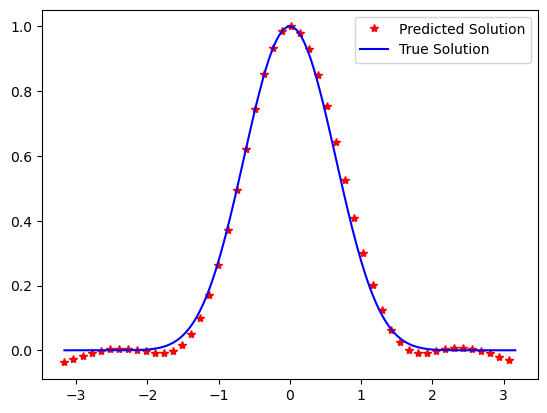

In [15]:
k = 10
x_test = torch.linspace(-L, L, 200).unsqueeze(dim=1) * torch.tensor([1.] * k + [0.] * (D-k)).type(torch.float)
plt.plot(np.linspace(-L * (k ** .5), L * (k ** .5), 200)[::4], u(x_test).squeeze().detach().numpy()[::4], "r*")
plt.plot(np.linspace(-L * (k ** .5), L * (k ** .5), 200), vmap(u_true)(x_test).detach().numpy(), "b")
# plt.ylim(190, 205)
plt.legend(["Predicted Solution", "True Solution"])
plt.savefig("200d_diag.png")
plt.show()

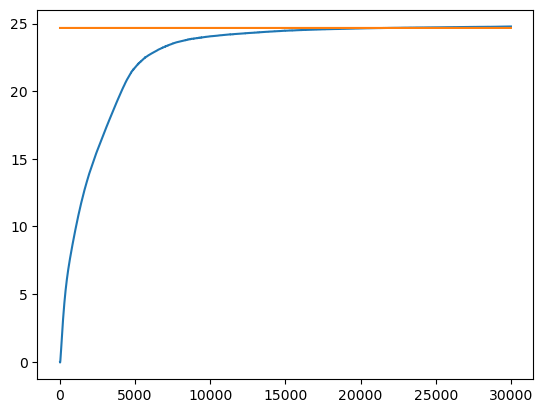

In [15]:
plt.plot(-eig_rec[:-1])
plt.plot(np.ones_like(eig_rec[:-1]) * (np.pi / 2 / L) ** 2 * D)
plt.show()

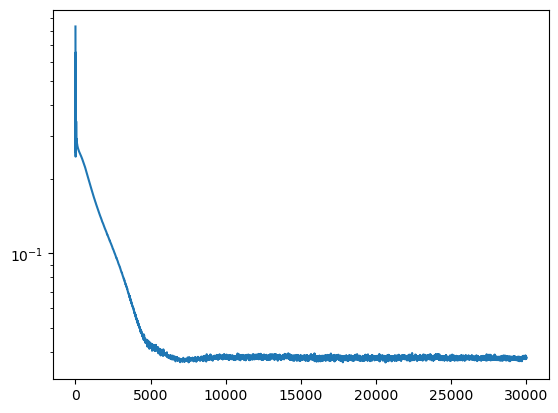

In [16]:
plt.semilogy(l2_err_rec[:-1])
plt.show()

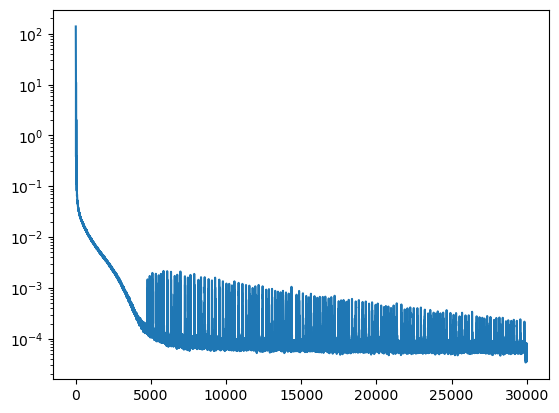

In [17]:
plt.semilogy(loss_rec[:-1])
plt.show()